In [2]:
import random
import glob
from scipy import ndimage
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [34]:
def sample_patches(images, count=5000, size=16):
    patches = np.empty((count, size, size))
    for i in range(count):
        image = random.choice(images)
        x = int(random.random() * (image.shape[0] - size))
        y = int(random.random() * (image.shape[1] - size))
    patches[i] = image[x: x + size, y: y + size]
    return patches

def show_patches(patches, rows, cols, title='Patches', size=10):
    assert len(patches) == rows * cols
    fig, ax = plt.subplots(
        nrows=rows, ncols=cols, figsize=(size, size / cols * rows),
        subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle(title)
    for x, y in itertools.product(range(rows), range(cols)):
        patch = patches[x * cols + y]
        ax[x, y].get_xaxis().set_visible(False)
        ax[x, y].imshow(patch, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

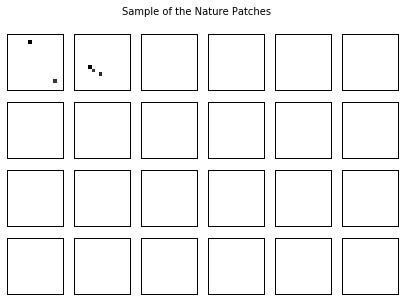

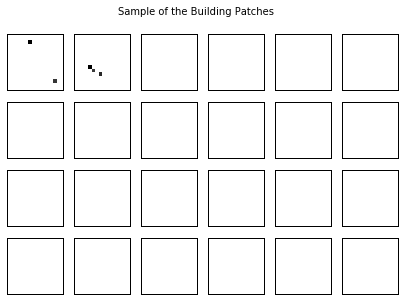

In [40]:
# Exercise 3.1

nature = [ndimage.imread(x) for x in glob.glob('imgpca/n*.jpg')]
buildings = [ndimage.imread(x) for x in glob.glob('imgpca/b*.jpg')]

nature = sample_patches(nature, 50)
buildings = sample_patches(buildings, 50)

show_patches(nature[:24] / 256, 4, 6, 'Sample of the Nature Patches', size=7)
show_patches(buildings[:24] / 256, 4, 6, 'Sample of the Building Patches', size=7)

nature = nature.reshape((len(nature), -1))
buildings = buildings.reshape((len(buildings), -1))